In [1]:
# 📦 Install required libraries (only needed in Colab)
!pip install -q transformers

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Feature Engineering & Model Training

We’ve explored and cleaned the data, it's time to transform the text into numerical features that can be used by machine learning models.

We’ll use the **TF-IDF vectorizer** to convert the cleaned reviews into feature vectors. Then, we’ll train a **Logistic Regression classifier** to predict the sentiment of each review.

This section includes:

- Splitting the data into training and testing sets
- Applying TF-IDF vectorization
- Training a logistic regression model
- Evaluating its performance using precision, recall, F1-score and confusion matrix

#### 1. Import Libraries

In [5]:
# Data handling and ML libraries
import pandas as pd
import numpy as np
import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

#### 2. Load the data

We load the cleaned dataset from the previous step (01_data_cleaning_and_eda), which contains the original feedback, a cleaned version, sentiment labels, and sentiment descriptions.

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hospital_reviews_project/dataset_hospital_reviews_cleaned.csv')

# Preview
df.head()

,feedback,sentiment_label,ratings,sentiment_desc,clean_text,text_length
0,Good and clean hospital. There is great team o...,1,5,Positive,good clean hospital great team doctor good ot ...,28
1,Had a really bad experience during discharge. ...,1,5,Positive,really bad experience discharge need sensitive...,11
2,I have visited to take my second dose and Proc...,1,4,Positive,visited take second dose process really smooth...,19
3,That person was slightly clueless and offered...,1,3,Positive,person slightly clueless offered one package g...,15
4,There is great team of doctors and good OT fac...,0,1,Negative,great team doctor good ot facility,6


#### 3. Train/test split

We begin by defining our features and target. The `clean_text` column will serve as input, while `sentiment_label` is our target variable.

We then split the data into training and testing sets using an 80/20 ratio to evaluate the model's generalization performance.

In [12]:
# Define features and target
X = df['clean_text']
y = df['sentiment_label']

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### 4. TF-IDF Vectorization

To convert the cleaned reviews into numerical representations, we use the TF-IDF (Term Frequency–Inverse Document Frequency) vectorizer.

We’ll limit the number of features to 3,000 to reduce dimensionality and training time.

In [13]:
# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)

In [14]:
print("TF-IDF matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF matrix shape (test):", X_test_tfidf.shape)

TF-IDF matrix shape (train): (796, 2001)
TF-IDF matrix shape (test): (200, 2001)


After applying TF-IDF vectorization, we now have a numerical representation of each review.
The matrix shape tells us how many reviews and unique tokens (words) are being used as features in the model.

#### 5. Train a Logistic Regression Model

We now train a Logistic Regression model using the TF-IDF features generated from the cleaned reviews.

This model will attempt to classify reviews as positive or negative based on the textual content.

In [15]:
# Initialize and train the model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

#### 6. Evaluate the Model

Once the model has been trained, we evaluate its performance on the test set using key classification metrics: **precision**, **recall**, **F1-score**, and **accuracy**.

We also generate a confusion matrix to visualize how well the model is distinguishing between positive and negative reviews.

In [16]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Print classification metrics
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.97      0.53      0.69        58
    Positive       0.84      0.99      0.91       142

    accuracy                           0.86       200
   macro avg       0.90      0.76      0.80       200
weighted avg       0.88      0.86      0.85       200

Confusion Matrix:
[[ 31  27]
 [  1 141]]


#### 6.1. Confusion Matrix Plot

This heatmap helps visually assess how many reviews were correctly or incorrectly classified by the model.

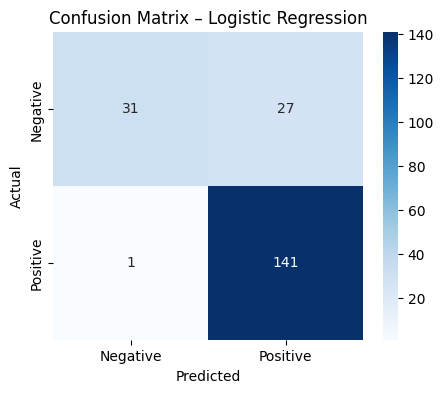

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Logistic Regression')
plt.show()

#### Observations:

The Logistic Regression model performed well overall, with excellent accuracy on positive reviews. It correctly classified **141 out of 142** positive reviews.

However, it struggled more with negative reviews, misclassifying **27 out of 58** as positive. This is likely due to class imbalance and the more subtle language used in negative feedback.

In the next step, we will compare this baseline with a Large Language Model (LLM) to see if we can improve performance, especially on the harder-to-detect negative cases.

#### 7. LLM Comparison – distilBERT Sentiment Classifier

To evaluate how a state-of-the-art language model performs on our dataset, we use the pretrained `distilbert-base-uncased-finetuned-sst-2-english` from Hugging Face.

This model is fine-tuned for sentiment analysis and returns a label of `POSITIVE` or `NEGATIVE` for each input review.

#### 7.1. Pipeline creation

In [19]:
# Load distilBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Take a sample of 100 reviews
sample_df = df.sample(100, random_state=42).copy()

# Apply the model to the cleaned reviews
sample_df['llm_result'] = sample_df['clean_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Show result
sample_df[['clean_text', 'sentiment_label', 'llm_result']].head()


Device set to use cpu


,clean_text,sentiment_label,llm_result
832,helping nature support lab staff worst use wor...,0,NEGATIVE
970,overall hospital well maintained hygienic clea...,1,POSITIVE
96,dr mohan keshavamurthy operated kidney stone l...,1,POSITIVE
587,wait hour despite appointment isnâ€™t first ti...,1,NEGATIVE
450,hi thank rating u star glad know positive expe...,1,POSITIVE


#### 7.2. Evaluation of LLM Predictions vs True Labels

In [22]:
# Convert numerical sentiment label to text for comparison
sample_df['true_label'] = sample_df['sentiment_label'].map({1: 'POSITIVE', 0: 'NEGATIVE'})

# Print metrics
print(classification_report(sample_df['true_label'], sample_df['llm_result']))

              precision    recall  f1-score   support

    NEGATIVE       0.54      0.96      0.69        26
    POSITIVE       0.98      0.72      0.83        74

    accuracy                           0.78       100
   macro avg       0.76      0.84      0.76       100
weighted avg       0.87      0.78      0.79       100



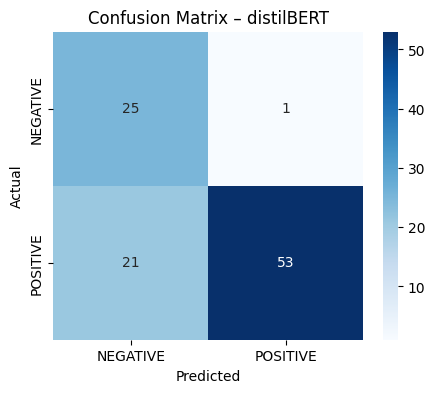

In [23]:
# Confusion matrix
cm = confusion_matrix(sample_df['true_label'], sample_df['llm_result'], labels=['NEGATIVE', 'POSITIVE'])

# Visual plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE', 'POSITIVE'], yticklabels=['NEGATIVE', 'POSITIVE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – distilBERT')
plt.show()

### Model Comparison Observations: Logistic Regression vs distilBERT

After training and evaluating both models on sentiment classification, we observed the following:

#### Logistic Regression (TF-IDF Features)
- Great precision on positive reviews
- Poor recall on negative reviews (many false positives)
- Struggled to identify nuanced negative feedback

#### distilBERT (LLM – Hugging Face)
- Very strong recall on **negative** reviews: 0.96
- Lower precision for negative class (0.54), possibly due to label noise or subtle review tone
- Overall more **balanced performance**, capturing more sentiment nuance

#### distilBERT Metrics on 100-Review Sample:
| Metric      | NEGATIVE | POSITIVE |
|-------------|----------|----------|
| Precision   | 0.54     | 0.98     |
| Recall      | 0.96     | 0.72     |
| F1-Score    | 0.69     | 0.83     |

**Accuracy**: 0.78  
**Macro F1**: 0.76

---

This experiment shows that even without fine-tuning, large language models like `distilBERT` outperform traditional models in handling open-ended patient feedback. They capture more subtle linguistic cues, especially in emotionally or contextually complex reviews.
